In [1]:
import keras
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import KFold

In [2]:
size = 224
dataset = []
label = []

In [3]:
covid_train = os.listdir("../input/covidxray/train/COVID19/")

for i, image_name in tqdm(enumerate(covid_train)):
    image = cv2.imread("../input/covidxray/train/COVID19/" + image_name) 
    image = Image.fromarray(image,'RGB')
    image = image.resize((size,size)) 
    dataset.append(np.array(image)) 
    label.append(0) 
    
    
covid_test = os.listdir("../input/covidxray/test/COVID19/") 

for i, image_name in tqdm(enumerate(covid_test)):
    image = cv2.imread("../input/covidxray/test/COVID19/" + image_name) 
    image = Image.fromarray(image,'RGB')
    image = image.resize((size,size)) 
    dataset.append(np.array(image)) 
    label.append(0) 

1056it [00:54, 19.33it/s]
262it [00:16, 15.64it/s]


In [4]:
normal_train = os.listdir("../input/covidxray/train/NORMAL/")

for i, image_name in tqdm(enumerate(normal_train)):
    image = cv2.imread("../input/covidxray/train/NORMAL/" + image_name) 
    image = Image.fromarray(image,'RGB')
    image = image.resize((size,size)) 
    dataset.append(np.array(image)) 
    label.append(1) 
    
    
normal_test = os.listdir("../input/covidxray/test/NORMAL/") 

for i, image_name in tqdm(enumerate(normal_test)):
    image = cv2.imread("../input/covidxray/test/NORMAL/" + image_name) 
    image = Image.fromarray(image,'RGB')
    image = image.resize((size,size)) 
    dataset.append(np.array(image)) 
    label.append(1) 

1266it [01:24, 15.00it/s]
262it [00:17, 14.73it/s]


In [5]:
pneumonia_train = os.listdir("../input/covidxray/train/PNEUMONIA/")

for i, image_name in tqdm(enumerate(pneumonia_train)):
    image = cv2.imread("../input/covidxray/train/PNEUMONIA/" + image_name) 
    image = Image.fromarray(image,'RGB')
    image = image.resize((size,size)) 
    dataset.append(np.array(image)) 
    label.append(2) 
    
    
pneumonia_test = os.listdir("../input/covidxray/test/PNEUMONIA/") 

for i, image_name in tqdm(enumerate(pneumonia_test)):
    image = cv2.imread("../input/covidxray/test/PNEUMONIA/" + image_name) 
    image = Image.fromarray(image,'RGB')
    image = image.resize((size,size)) 
    dataset.append(np.array(image)) 
    label.append(2) 

1550it [00:55, 28.12it/s]
262it [00:07, 35.76it/s]


In [6]:
print(len(dataset))
print(len(label))

4658
4658


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense,  Dropout
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

classes_number=3 #Number of classes
input_tensor=Input(shape=(224,224,3))

In [4]:
## Splitting the data
np.random.seed(42)

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

**STACKING BEGINS**

In [5]:
model1 = tf.keras.models.load_model("DenseNet201_1.h5")
features1 = model1.output

model2 = tf.keras.models.load_model("ResNet50.h5")
features2 = model2.output

model3 = tf.keras.models.load_model("VGG19.h5")
features3 = model3.output

In [6]:
for name, layer in enumerate(model2.layers):
    layer._name = 'layer_'+str(name)+'layer_'
    
for name, layer in enumerate(model3.layers):
    layer._name = 'layer_'+str(name)+'layer_'+'layer_'    

In [7]:
concatenated=tf.keras.layers.Concatenate()([features1,features2,features3]) #Concatenate the extracted features

In [8]:
x= tf.keras.layers.Flatten(name='f1')(concatenated)

x= Dense(128,activation='relu',name='dn1')(x)
x= BatchNormalization(name = 'bn1')(x)
x= Dropout(0.5,name='d1')(x)

preds = Dense(classes_number, activation='softmax',name='dn3')(x)

Concatenated_model = Model(inputs= [model1.input,model2.input,model3.input] , outputs= preds )

In [9]:
for layer in Concatenated_model.layers[:-5]:
    layer.trainable=False
    
for layer in Concatenated_model.layers[-5:]:
    layer.trainable=True

optimizer = Adam()
early_stop = EarlyStopping(monitor='val_loss', patience= 5 , verbose=1, mode='min', restore_best_weights = True)  
Concatenated_model.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

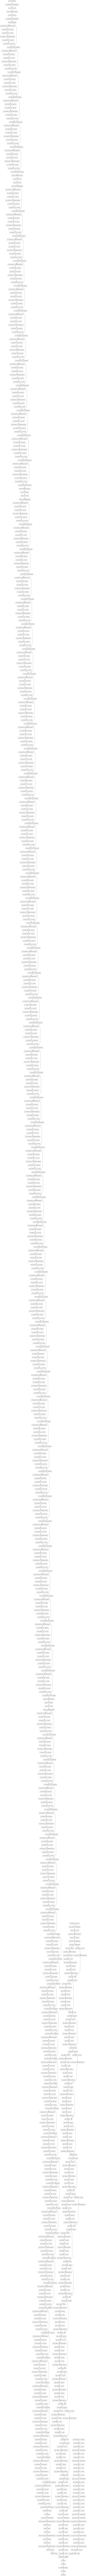

In [14]:
from keras.utils import plot_model
plot_model(Concatenated_model)

In [15]:
del model1
del model2
del model3

#######################################################################################################################
CV Fold starts now..........
Epoch 1/100
117/117 [==============================] - 57s 327ms/step - loss: 0.6060 - accuracy: 0.7716 - val_loss: 0.3390 - val_accuracy: 0.9882
Epoch 2/100
117/117 [==============================] - 30s 260ms/step - loss: 0.0477 - accuracy: 0.9860 - val_loss: 0.1178 - val_accuracy: 0.9871
Epoch 3/100
117/117 [==============================] - 30s 259ms/step - loss: 0.0431 - accuracy: 0.9910 - val_loss: 0.0509 - val_accuracy: 0.9871
Epoch 4/100
117/117 [==============================] - 30s 259ms/step - loss: 0.0510 - accuracy: 0.9902 - val_loss: 0.0427 - val_accuracy: 0.9871
Epoch 5/100
117/117 [==============================] - 30s 259ms/step - loss: 0.0432 - accuracy: 0.9896 - val_loss: 0.0426 - val_accuracy: 0.9882
Epoch 6/100
117/117 [==============================] - 30s 259ms/step - loss: 0.0477 - accuracy: 0.9876 - val_loss: 0.046

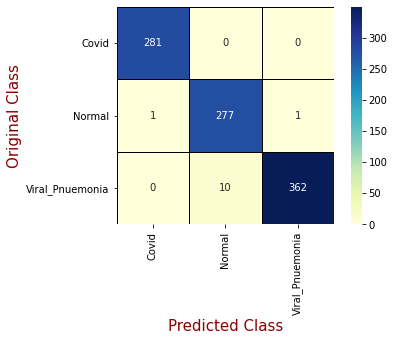

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       281
           1       0.97      0.99      0.98       279
           2       1.00      0.97      0.99       372

    accuracy                           0.99       932
   macro avg       0.99      0.99      0.99       932
weighted avg       0.99      0.99      0.99       932

........CV Fold ends
#######################################################################################################################
CV Fold starts now..........
Epoch 1/100
117/117 [==============================] - 31s 262ms/step - loss: 0.0446 - accuracy: 0.9901 - val_loss: 0.0401 - val_accuracy: 0.9914
Epoch 2/100
117/117 [==============================] - 30s 260ms/step - loss: 0.0356 - accuracy: 0.9911 - val_loss: 0.0389 - val_accuracy: 0.9914
Epoch 3/100
117/117 [==============================] - 30s 260ms/step - loss: 0.0410 - accuracy: 0.9898 - val_loss: 0.0327 - val_accuracy: 0.9903
Epoch 4/100

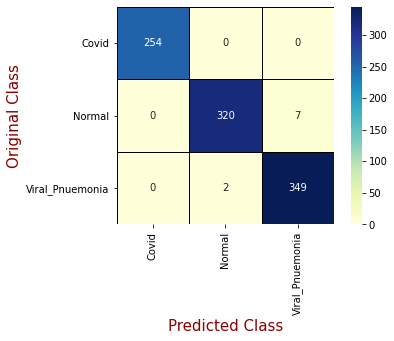

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       254
           1       0.99      0.98      0.99       327
           2       0.98      0.99      0.99       351

    accuracy                           0.99       932
   macro avg       0.99      0.99      0.99       932
weighted avg       0.99      0.99      0.99       932

........CV Fold ends
#######################################################################################################################
CV Fold starts now..........
Epoch 1/100
117/117 [==============================] - 31s 263ms/step - loss: 0.0465 - accuracy: 0.9903 - val_loss: 0.0223 - val_accuracy: 0.9936
Epoch 2/100
117/117 [==============================] - 30s 260ms/step - loss: 0.0442 - accuracy: 0.9901 - val_loss: 0.0216 - val_accuracy: 0.9936
Epoch 3/100
117/117 [==============================] - 30s 260ms/step - loss: 0.0437 - accuracy: 0.9885 - val_loss: 0.0223 - val_accuracy: 0.9936
Epoch 4/100

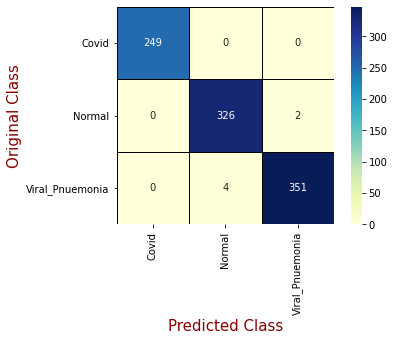

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       249
           1       0.99      0.99      0.99       328
           2       0.99      0.99      0.99       355

    accuracy                           0.99       932
   macro avg       0.99      0.99      0.99       932
weighted avg       0.99      0.99      0.99       932

........CV Fold ends
#######################################################################################################################
CV Fold starts now..........
Epoch 1/100
117/117 [==============================] - 31s 262ms/step - loss: 0.0473 - accuracy: 0.9914 - val_loss: 0.0213 - val_accuracy: 0.9936
Epoch 2/100
117/117 [==============================] - 30s 260ms/step - loss: 0.0464 - accuracy: 0.9882 - val_loss: 0.0201 - val_accuracy: 0.9936
Epoch 3/100
117/117 [==============================] - 30s 259ms/step - loss: 0.0430 - accuracy: 0.9895 - val_loss: 0.0220 - val_accuracy: 0.9925
Epoch 4/100

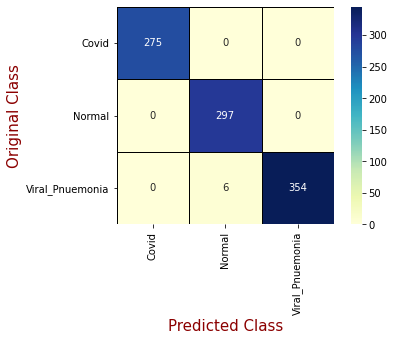

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       275
           1       0.98      1.00      0.99       297
           2       1.00      0.98      0.99       360

    accuracy                           0.99       932
   macro avg       0.99      0.99      0.99       932
weighted avg       0.99      0.99      0.99       932

........CV Fold ends
#######################################################################################################################
CV Fold starts now..........
Epoch 1/100
117/117 [==============================] - 31s 262ms/step - loss: 0.0417 - accuracy: 0.9882 - val_loss: 0.0194 - val_accuracy: 0.9925
Epoch 2/100
117/117 [==============================] - 30s 259ms/step - loss: 0.0428 - accuracy: 0.9890 - val_loss: 0.0216 - val_accuracy: 0.9903
Epoch 3/100
117/117 [==============================] - 30s 259ms/step - loss: 0.0450 - accuracy: 0.9887 - val_loss: 0.0239 - val_accuracy: 0.9903
Epoch 4/100

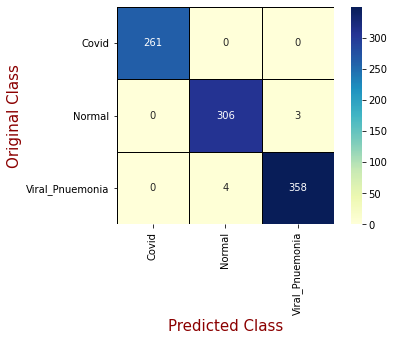

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       261
           1       0.99      0.99      0.99       309
           2       0.99      0.99      0.99       362

    accuracy                           0.99       932
   macro avg       0.99      0.99      0.99       932
weighted avg       0.99      0.99      0.99       932

........CV Fold ends
Estimated Accuracy 99.36


In [16]:
from sklearn.metrics import  confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

callbacks = [early_stop]

n_folds = 5
cv_scores = list()

for _ in range(n_folds):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.20)
    # evaluate model
    
    print("#######################################################################################################################")
    print("CV Fold starts now..........")
    
    history = Concatenated_model.fit([np.array(X_train),np.array(X_train),np.array(X_train)],   
                         y_train, 
                         batch_size = 32, 
                         verbose = 1, 
                         epochs = 100,      
                         validation_data=([np.array(X_test),np.array(X_test),np.array(X_test)], y_test),
                         shuffle = False,
                         callbacks=callbacks)
    
    val_acc = Concatenated_model.evaluate((np.array(X_test),np.array(X_test),np.array(X_test)), np.array(y_test))[1]*100
    cv_scores.append(val_acc)
    
    Y_pred_concat = Concatenated_model.predict([np.array(X_test),np.array(X_test),np.array(X_test)])
    y_pred_concat = np.argmax(Y_pred_concat, axis=1)

    y_classes = [np.argmax(y, axis=None, out=None) for y in y_test]

    cnf_matrix = confusion_matrix(y_classes, y_pred_concat)
    cm = pd.DataFrame(cnf_matrix, columns = ['Covid', 'Normal', 'Viral_Pnuemonia'], 
                      index = ['Covid', 'Normal', 'Viral_Pnuemonia'])

    font = {'family': 'times new roman',
            'color':  'darkred',
            'weight': 'normal',
            'size': 15,
            }


    heat_map = sns.heatmap(cm, annot = True, square = True, linewidths= 0.5, linecolor= 'black',
                       cmap = 'YlGnBu', fmt = 'g', robust = True)

    heat_map.set_xticklabels(heat_map.get_xticklabels(), rotation = 90)
    heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation = 0)
    plt.xlabel('Predicted Class', fontdict= font)
    plt.ylabel('Original Class', fontdict= font)
    plt.show()
    

    print(classification_report(y_classes, y_pred_concat))
    
    print("........CV Fold ends")
    
print("================================================================================================================")    
print('Estimated Accuracy %.2f' % (np.max(cv_scores)))
    

In [20]:
Concatenated_model.save("Concatenated_model.h5")